In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from zennit.composites import LayerMapComposite, EpsilonPlus, EpsilonAlpha2Beta1
import matplotlib.pyplot as plt

from pnpxai.explainers import LRP
from pnpxai.explainers.utils.post_process import postprocess_attr

from helpers import get_imagenet_dataset, get_torchvision_model, denormalize_image

model, transform = get_torchvision_model("vit_b_16")
dataset = get_imagenet_dataset(transform, subset_size=8)
loader = DataLoader(dataset, batch_size=8)
inputs, labels = next(iter(loader))
targets = labels

explainer = LRP(model)
composite_types = [LayerMapComposite, EpsilonPlus, EpsilonAlpha2Beta1]
# attributions = explainer.attribute(inputs, targets) #, composite_type=EpsilonPlus)

t = .05
heatmaps = []
for composite_type in composite_types:
    attrs = explainer.attribute(inputs, targets, composite_type=composite_type)
    hms = []
    for attr in attrs:
        # bounding
        lb = attr.quantile(t)
        ub = attr.quantile(1-t)
        bounded = attr - F.relu(attr-ub) + F.relu(-attr+lb)

        # min-max scale
        hms.append(postprocess_attr(bounded))
    heatmaps.append(hms)

/home/gkim/Projects/pnpxai/.venv/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/gkim/Projects/pnpxai/.venv/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/gkim/Projects/pnpxai/.venv/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/gkim/Projects/pnpxai/.venv/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/home/gkim/Projects/pnpxai/pnpxai/explainers/lrp/captum_like.py:39: UserWarning: 
[LRP] Warning: 25 add operations in function detected. Automatically changed to modules.
  warnings.warn(


<class 'torch.nn.modules.normalization.LayerNorm'> tensor(-0.4646) tensor(-0.4625)
<class 'torch.nn.modules.normalization.LayerNorm'> tensor(3597.3799) tensor(3597.3584)
<class 'torch.nn.modules.activation.MultiheadAttention'> tensor(-1499.1285) tensor(-1495.1288)
<class 'torch.nn.modules.normalization.LayerNorm'> tensor(-4485.3862) tensor(-4485.5093)
<class 'torch.nn.modules.normalization.LayerNorm'> tensor(-14299.8994) tensor(-14322.6758)
<class 'torch.nn.modules.activation.MultiheadAttention'> tensor(-5245496.5000) tensor(-5246562.)
<class 'torch.nn.modules.normalization.LayerNorm'> tensor(-15739694.) tensor(-15739612.)
<class 'torch.nn.modules.normalization.LayerNorm'> tensor(3148704.) tensor(3151733.)
<class 'torch.nn.modules.activation.MultiheadAttention'> tensor(3.6916e+08) tensor(3.7005e+08)
<class 'torch.nn.modules.normalization.LayerNorm'> tensor(1.1102e+09) tensor(1.1101e+09)
<class 'torch.nn.modules.normalization.LayerNorm'> tensor(-2.6313e+09) tensor(-2.6331e+09)
<class 't

Text(0.5, 1.0, 'Alpha2Beta1')

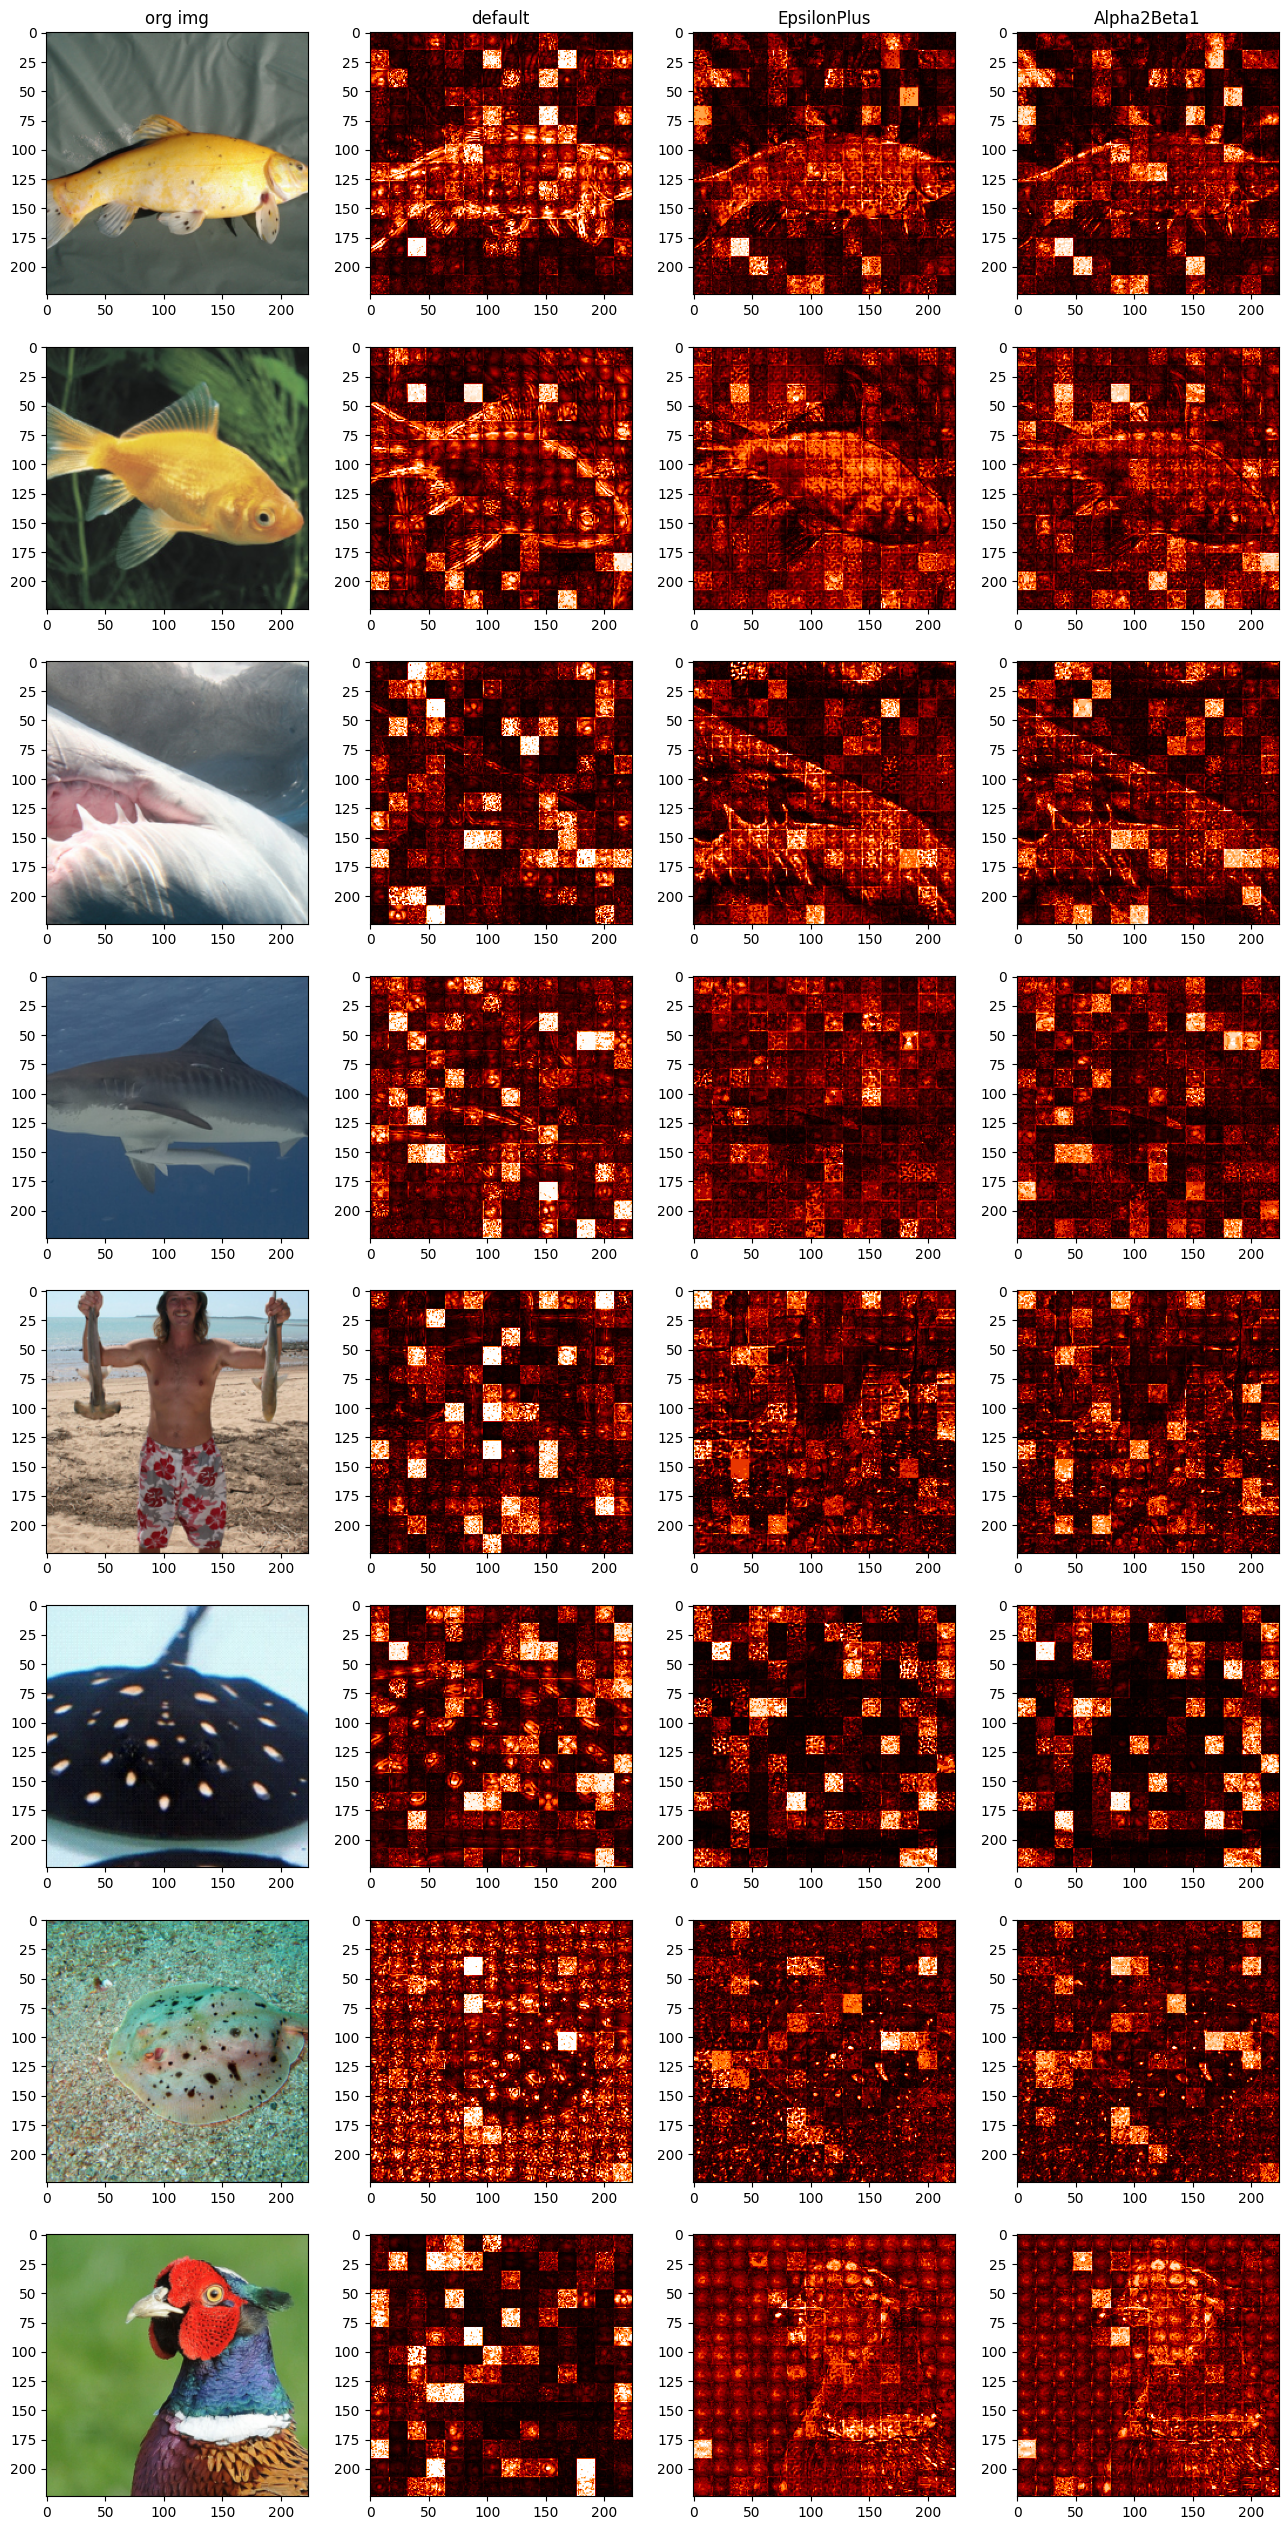

In [3]:
ncols = 1 + len(composite_types)
nrows = len(inputs)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
for i, (input, hm0, hm1, hm2) in enumerate(zip(inputs, *heatmaps)):
    axes[i, 0].imshow(denormalize_image(input, mean=transform.mean, std=transform.std))
    axes[i, 1].imshow(hm0, cmap="gist_heat")
    axes[i, 2].imshow(hm1, cmap="gist_heat")
    axes[i, 3].imshow(hm2, cmap="gist_heat")

axes[0, 0].set_title("org img")
axes[0, 1].set_title("default")
axes[0, 2].set_title("EpsilonPlus")
axes[0, 3].set_title("Alpha2Beta1")